## Market Prediction Using ExtraTreesClassifier 🚀

**Description**: The supplied dataset contains a set of features, feature_, goes 0 ... 129, representing actual stock market data. Each row in the data set represents a trading opportunity, for which we will be predicting a stock value: 1 to make the trade and 0 to pass it. Each operation has an associated weight and resp, which together represents a return on the trade. In the training set, tren.csv, you are given a resp value, as well as several other resp_ values of 1,2,3,4 that represent returns at different time horizons.

In Test set we don't have resp value, and other resp_{1,2,3,4} data, so we have to use only feature_{0...129} to make prediction.

### Contents

* Libraries
* Loading and Reduce Memory
* EDA
* Preprocesing
* Define model || ExtraTreesClassifier
* Reducing dimensionality || PCA
* Test model in All dataset
* Submitting


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **Libraries** 📘

In [ ]:
import zipfile
import warnings
import pandas as pd
import numpy as np
from numpy import mean, std
import datatable as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA, NMF

#warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
%pylab
%matplotlib inline

## **Loading and Reduce Memory** 💾 

We load the data, trying to reduce the memory overload  
Reference: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

In [ ]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
%%time

df_train = (
    dt.fread('../input/jane-street-market-prediction/train.csv', max_nrows=200000)
      .to_pandas()
      .pipe(reduce_mem_usage)
)
df_train.head()

## EDA 🔬
T
he goal of this notebook is not to do a thorough data exploration, as there are great jobs that develop this task. Based on these findings, we will try to develop a quick method optimized to predict Jane Street's challenge

Reference:https://www.kaggle.com/muhammadmelsherbini/jane-street-extensive-eda

## Preprocesing ⚙  

* We calculate the target from the variable 'resp'
* We erase cases where the weight is equal to 0. Weighted operations 0 were intentionally included in the dataset to be complete, although such operations will not contribute to the assessment of the score. Then we'll ignore it.

In [ ]:
# Drop rows with 'weight'=0 
df_train = df_train[df_train['weight']!=0]
#df_train = df_train.loc[df_train.weight != 0]

# Create 'action' column (target)
# The objetive is maximise the utility function pi=∑j(weightij∗respij∗actionij) where positive values of resp will increase pi
#df_train['action'] = df_train['resp'].apply(lambda x:x>0).astype(int)
df_train['action'] = (df_train['resp'] > 0).astype('int')

#Select the model´s variables (features alone)
features = [c for c in df_train.columns if 'feature' in c]
#df_train = pd.concat([df_train[features],df_train.action], axis=1)

X = df_train[features]
y = df_train['action']

* treat infinite values
* treat null values

In [ ]:
###INF Values##
X.replace([np.inf, -np.inf], np.nan, inplace=True)

###NAN Values##

#First estrategy
#Fill nan values with 0
X.fillna(0,inplace=True)

#Second estrategy
#Fill nan values with median
#X_median = X.median()
#X = X.fillna(train_median)


#Third estrategy
#Lineal Interpolation
#X.interpolate(method='linear', inplace=True)


In [ ]:
X.isnull().sum().sum()

## Define model 🔍 || ExtraTreesClassifier  

The choice of this model is defined by the performance comparison we developed from this [Notebook](https://www.kaggle.com/jlfdatascience/automl-approach-model-selection)  

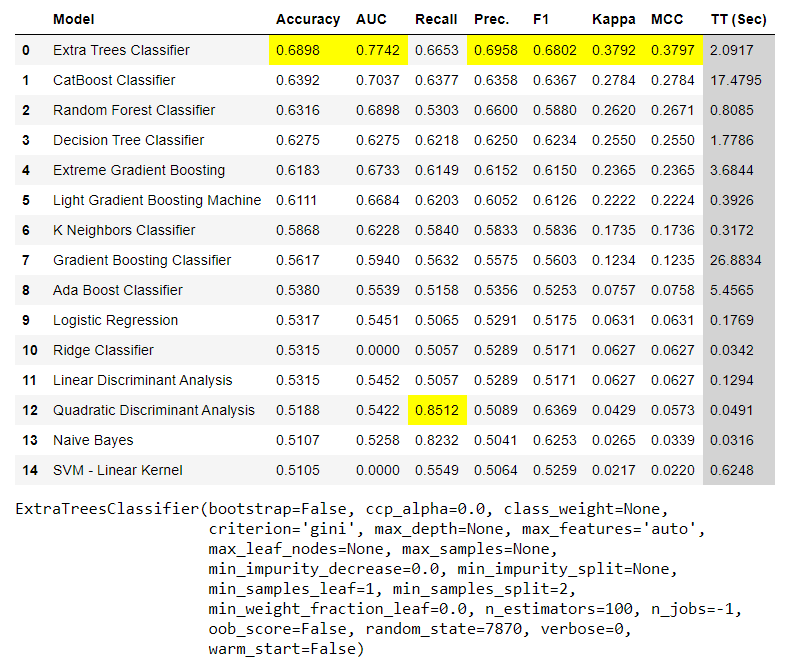![](http://../input/images/Compare_accuracy_Model.jpg)

In [ ]:
# define the model from PyCaret Optimization
etc = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     oob_score=False, verbose=0,
                     warm_start=False)

In the case of this challenge there is a time limitation for model execution so it is advisable to decrease the dimensionality. To do this we will use PCA and cross-validation what are the optimal component numbers to be able to get better performance.

## Reducing dimensionality || PCA

We observe what dimensionality with the PCA method and hyperparameters of the ETC model can give us the best performance. Test the model with cross-validation ([RepeatedStratifiedKFold](https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece)). It is exciting to use in this case all the data because the cross-validation itself divides the data into training and validation.  
Several iterations are performed with different parameters so that the process consumes less memory.

### We automate the process with Pipeline
To apply PCA method, we need to normalize the data so we introduce in the pipeline the allocation of the median to the possible missing data (although we already process it previously) and normalize the data, then apply the dimensionality reduction and finally the selected prediction method.

In [ ]:
%%time

pca= PCA()
et = ExtraTreesClassifier()

pipe_pca = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('model', et)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': range(4,16,4),
}

search = GridSearchCV(pipe_pca, param_grid=param_grid, n_jobs=-1)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [ ]:
%%time

pca= PCA(n_components=12)
#et = ExtraTreesClassifier(criterion='entropy', random_state=0, n_estimators=100, max_depth=75)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

pipe_pca = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), #, fill_value = 0
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('model', etc)])

# Parameters of pipelines can be set using name +‘__’+ parameter names:
param_grid = {
    #'pca__n_components': range(4,16,4),
    'model__criterion': ['entropy'],#['gini', 'entropy'], #grid.best_params_ = {'criterion': 'entropy'}
    'model__n_estimators': [100],#range(25,125,25),#grid.best_params_ = {'n_estimators': 100}
    'model__max_depth': [75], #range(1,100,25),#grid.best_params_ = {'max_depth': 100}
    #'max_features': [100],#range(50,150,50),#grid.best_params_ = {'n_estimators': 100}
    #'model__min_samples_leaf': range(1,30,10),#grid.best_params_ = {'min_samples_leaf': 1}
     #'min_samples_split': range(1,50,5),
    #'et__random_state': [0],
}

et_pca = GridSearchCV(pipe_pca, param_grid=param_grid, n_jobs=-1, cv=cv)
et_pca.fit(X, y)
print("Best parameter (CV score=%0.3f):" % et_pca.best_score_)
print(et_pca.best_params_)

In [ ]:
ExtraTreesClassifier().get_params().keys()

* ## Test model in All dataset
* Load all dataset
* We divide the dataset into train and test to check the performance of the trained model.

In [ ]:
%%time

df_all = (
    dt.fread('../input/jane-street-market-prediction/train.csv')
      .to_pandas()
      .pipe(reduce_mem_usage)
)
df_all.head()

### Preprocessing

In [ ]:
# Drop rows with 'weight'=0 
df_all = df_all[df_all['weight']!=0]
#df_train = df_train.loc[df_train.weight != 0]

# Create 'action' column (target)
# The objetive is maximise the utility function pi=∑j(weightij∗respij∗actionij) where positive values of resp will increase pi
#df_train['action'] = df_train['resp'].apply(lambda x:x>0).astype(int)
df_all['action'] = (df_all['resp'] > 0).astype('int')

#Select the model´s variables (features alone)
features = [c for c in df_all.columns if 'feature' in c]
#df_train = pd.concat([df_train[features],df_train.action], axis=1)

X_all = df_all[features]
y_all = df_all['action']

###INF Values##
X_all.replace([np.inf, -np.inf], np.nan, inplace=True)

###NAN Values##

#Fill nan values with 0
X_all.fillna(0,inplace=True)

In [ ]:
# Train and test data
train_x, test_x, train_y, test_y = train_test_split(X_all, y_all, test_size=0.3)

We generate a function to be able to automate model metrics

In [ ]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

def metrics_models(y_true, y_pred):
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)

    print("La matriz de confusión es ")
    print(confusion_matrix)

    print('Precisión:', accuracy_score(y_true, y_pred))
    print('Exactitud:', precision_score(y_true, y_pred))
    print('Exhaustividad:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print('AUC:', auc(false_positive_rate, recall))

    plot(false_positive_rate, recall, 'b')
    plot([0, 1], [0, 1], 'r--')
    title('AUC = %0.2f' % roc_auc)

In [ ]:
#Test with train and test set to see if there is overfit in model performance
y_pred = et_pca.predict(train_x)

metrics_models(train_y, y_pred)

In [ ]:
#We see if there is overfit in the df test
y_pred_test = et_pca.predict(test_x)
metrics_models(test_y, y_pred_test)

There doesn't seem to be any overfits

In [ ]:
#free some space
del train_x, test_x, train_y, test_y, df_train

## Submitting

In [ ]:
from tqdm import tqdm
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

In [ ]:
#Reference:https://www.kaggle.com/vivekanandverma/eda-xgboost-hyperparameter-tuning
for (test_df, pred_df) in tqdm(iter_test):
    if test_df['weight'].item() > 0:
        X_test = test_df.loc[:, test_df.columns.str.contains('feature')]
        y_preds = et_pca.predict(X_test)
        pred_df.action = y_preds
    else:
        pred_df.action = 0
    env.predict(pred_df)